In [1]:
import sys
import os
changed_dir = False
if(not changed_dir):
    os.chdir(os.path.join(os.getcwd(), "../"))
    sys.path.append(os.getcwd())
    print(os.getcwd())
    changed_dir = True

/home/anupa/Netmon/NetMon-query-planner/gurobi


In [2]:
import input
from input import draw_overlay_over_tenant, draw_graph

/home/anupa/miniconda3/envs/wbase/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.spectral module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
import numpy as np
import random
import math
import time
import ipdb
import traceback

from collections import namedtuple
from input import TreeTopology, eps0, flatten
from main import solve
from config import common_config
from common import setup_logging, Namespace
import matplotlib.pyplot as plt
from clos import Clos

common_config.solver = 'Netmon'
common_config.vertical_partition = True
common_config.prog_dir = None
common_config.perf_obj = True
common_config.MAX_DEVICES_PER_CLUSTER = 8
setup_logging(common_config)

In [54]:
problem = TreeTopology(hosts_per_tors=8, num_queries=4*8, tenant=True,
                       eps=eps0, overlay='none', refine=False,
                       queries_per_tenant=8, portion_netronome=0)
# problem = Clos(pods=16, overlay='none', query_density=1, portion_netronome=1)

to_run = [('Optimal', 'none'), ('Spectral-comm', 'spectralA'), ('Spectral-topo', 'spectral'), 
          ('Multi-tenant', 'tenant'), ('Discretize', 'kmedoids')]

# problem.overlay = 'none'
# schemes.append(Scheme('Optimal', problem.get_input(), None))

# problem.overlay = 'spectralA'
# schemes.append(Scheme('Spectral-communication', problem.get_input(), None))

# problem.overlay = 'spectral'
# schemes.append(Scheme('Spectral-topology', problem.get_input(), None))

In [68]:
num_runs = 10
schemes = []
Scheme = namedtuple('Scheme', ['name', 'inp', 'obj'])
for s in to_run:
    problem.overlay = s[1]
    obj_count = 0
    obj_sum = 0
    for i in range(num_runs):
        inp = problem.get_input()
        r = solve(inp)
        if(r):
            obj_sum += r.results.res
            obj_count += 1
    obj = None
    obj = obj_sum / obj_count
    schemes.append(Scheme(s[0], inp, obj))
    print(s[0], obj)

Optimal 13909.92854142189
Spectral-comm 14499.3220508701
Spectral-topo 15590.041570368336
Multi-tenant 14404.604786396023
Discretize 14308.790387075616


In [14]:
'''
Goal: Find best overlay for a given input
'''
problem.overlay = 'kmedoids'
INP = problem.get_input()
x0 = np.array(flatten(INP.overlay))
# random.shuffle(x0)

ELEMENTS_PER_PART = 8
NITER = 500

OPT = schemes[0].obj
RANDOM = schemes[2].obj
# OPT = 2105
# SPECTRALA = 2134
# TENANT = 2135
# TOR = 2295
# RANDOM = 2315

TSTART = (RANDOM - OPT) / 2
TSTOP = 5


class Anneal():

    def __init__(self, func, x0, Tstart, Tstop, take_step,
                 alpha=0.995, niter=100, callback=None):
        self.func = func
        self.x0 = x0
        self.Tstart = Tstart
        self.Tstop = Tstop
        self.niter = niter
        self.take_step = take_step
        self.alpha = alpha
        self.callback = callback

    def accept_reject(self, energy_new, energy_old):
        if(energy_new is None):
            return False
        if(energy_new < energy_old):
            return True
        else:
            # import ipdb; ipdb.set_trace()
            # print("DeltaE: {}".format(energy_new - energy_old))
            # print("Exp: {}".format( -(energy_new - energy_old)/self.T ))
            # print("Prob: {}".format(math.exp(
            #     -(energy_new - energy_old)/self.T)))
            return random.random() <= math.exp(
                -(energy_new - energy_old)/self.T
            )

    def anneal(self):

        x = self.x0
        f = self.func(x)
        if(getattr(self, 'callback', None)):
            self.callback(x, f, True)

        self.iteration = 0
        self.T = self.Tstart
        while self.T >= self.Tstop and self.iteration < self.niter:

            x_after_step = np.copy(x)
            x_after_step = self.take_step(x_after_step)
            f_after_step = self.func(x_after_step)
            accept = self.accept_reject(f_after_step, f)

            if(getattr(self, 'callback', None)):
                val = self.callback(x_after_step, f_after_step, accept)
                if(val):
                    break

            if(accept):
                f = f_after_step
                x = x_after_step

            self.T *= self.alpha
            self.iteration += 1


class TakeStep():
    def __init__(self, stepsize=1):
        self.stepsize = stepsize

    def __call__(self, perm):
        n = len(perm)
        l = random.randint(2, int((n - 1) * self.stepsize))
        i = random.randint(0, n - l)
        perm = perm.tolist()
        perm[i: (i + l)] = reversed(perm[i: (i + l)])
        return np.array(perm)


class Callback():
    def __init__(self):
        self.data = []
        self.best = Namespace(x=x0, f=func(x0))

    def __call__(self, x, f, accept):
        print(x, f, accept)
        self.data.append(tuple((x, f, accept)))
        if(accept):
            if(f is not None):
                if(f < self.best.f):
                    self.best.x = x
                    self.best.f = f

        if(f is not None):
            if(abs(f - OPT) < TSTOP):
                return True


# No side effects
def get_overlay_from_perm(perm):
    n = len(perm)
    split_parts = math.floor(n/ELEMENTS_PER_PART)
    covered_elements = split_parts * ELEMENTS_PER_PART
    splits = np.split(
        perm[:covered_elements],
        split_parts)
    splits = [x.astype(int).tolist() for x in splits]
    splits[-1].extend(perm[covered_elements:].astype(int).tolist())
    return splits


def func(perm):
    INP.overlay = get_overlay_from_perm(perm)
    # start = time.time()
    r = solve(INP)
    # print(ns, res)
    # end = time.time()
    if(r):
        return r.results.res  # ((res + 10000) * ns)/1000
    else:
        return None

In [ ]:
cb = Callback()
ts = TakeStep()
simanneal = Anneal(func, x0,
                   take_step=ts, callback=cb, Tstart=TSTART, Tstop=TSTOP,
                   niter=2000)
simanneal.anneal()
import pickle

In [71]:
cb_file = open('pickle_objs/cb-nsdi', 'wb')
pickle.dump(cb, cb_file)
cb_file.close()
print(cb.best)

{'x': array([ 5,  1, 27, 30, 31,  4, 36, 32, 21, 20,  8, 18, 28,  2, 12, 34, 14,
       25, 13,  7,  3, 33, 16, 19,  9, 10, 29, 24, 17,  0, 26, 23, 37, 22,
       38, 11,  6, 15, 35]), 'f': 14308.40659737587}


[[1, 5, 14, 23, 26, 27, 28, 25], [19, 16, 13, 7, 3, 0, 38, 37], [36, 11, 15, 20, 21, 22, 24, 29], [2, 8, 9, 10, 12, 17, 18, 33, 34, 6, 4, 35, 31, 30, 32]]


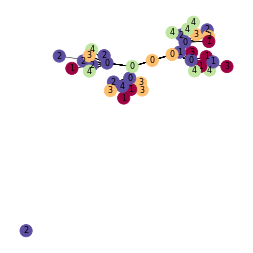

In [16]:
get_overlay_from_perm(x0)
ov = get_overlay_from_perm(cb.best.x)
print(ov)

INP.overlay = ov
draw_overlay_over_tenant(INP)

In [17]:
# common_config.MAX_DEVICES_PER_CLUSTER=8
# specA = TreeTopology(hosts_per_tors=8, num_queries=4*8, tenant=True,
#                     overlay='spectralA', refine=True,
#                     queries_per_tenant=8).get_input()
# draw_overlay_over_tenant(specA)

In [18]:
# r = solve(specA)
# r.results.res

In [22]:
cb_file = open('pickle_objs/cb-opt', 'rb')
cb = pickle.load(cb_file)
cb_file.close()

In [19]:
# ten = TreeTopology(hosts_per_tors=8, num_queries=4*8, tenant=True,
#             overlay='spectral', refine=True,
#             queries_per_tenant=8).get_input()
# draw_overlay_over_tenant(ten)

In [83]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import palettable
FONT_SIZE = 8
MARKER_SIZE = 6
LINE_WIDTH = 1.5
HANDLE_LENGTH = 2.5
FIGURE_SIZE = (16/3, 9/3)
colors = palettable.colorbrewer.qualitative.Paired_12.hex_colors
colors_idxs = [1, 5, 3, 7, 9, 11]
linestyles = ['-', '--']
hatches = ['-', '\\\\', '', 'X']
markers = ['x', '^', 'D', 'o', '.', 's']

plt.rcParams.update({
    'font.size': FONT_SIZE,
    'lines.linewidth': LINE_WIDTH
})
plt.rc('pdf', fonttype=42)

# https://jwalton.info/Embed-Publication-Matplotlib-Latex/

def get_fig_size(col=1, height_frac=1):
    width = LATEX_LINE_WIDTH_IN * col
    height = width * GOLDEN_RATIO * height_frac
    return (width, height)


def pt2in(pt):
    return pt/72.72


LATEX_TEXT_WIDTH_PT = 505.89
LATEX_TEXT_WIDTH_IN = pt2in(LATEX_TEXT_WIDTH_PT)
LATEX_LINE_WIDTH_PT = 241.02039
LATEX_LINE_WIDTH_IN = pt2in(LATEX_LINE_WIDTH_PT)
GOLDEN_RATIO = (5**.5 - 1) / 2

Optimal 13909.92854142189
Spectral-comm 14499.3220508701
Spectral-topo 15590.041570368336
Multi-tenant 14404.604786396023


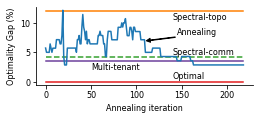

In [119]:
linestyles = ['-']*2 + ['--'] + ['-']*2 + ['--'] + ['-']*5
fig, ax = plt.subplots(figsize=get_fig_size(1/0.85, 0.6))
anneal_obj = [(x[1]-OPT)*100/OPT for x in cb.data if x[2]]
xs = list(range(len(anneal_obj)))
xtext = [140]*6
xtext[4] = 50
ytext = [0.5]*6
ytext[4] = -1.5
ytext[3] = -1.5
for idx_1, s in enumerate(schemes):
    idx = idx_1 + 1
    if(idx == 5): 
        continue
    ys = [(s.obj-OPT)*100/OPT for xxs in xs]
    ax.plot(xs, ys, lw=LINE_WIDTH, linestyle=linestyles[idx], c=colors[colors_idxs[idx]])
    plt.text(xtext[idx], ys[0]+ytext[idx], s.name)
    print(s.name, s.obj)

# cb.data.sort(key=lambda x: x[1])
idx = 0
plt.plot(xs, anneal_obj, label="Annealing", lw=LINE_WIDTH, linestyle=linestyles[idx], c=colors[colors_idxs[idx]])


ax.set_xlabel('Annealing iteration')
ax.set_ylabel('Optimality Gap (%)')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(labelsize=FONT_SIZE, pad=2)
# legend = plt.legend(loc='upper right', numpoints=1, bbox_to_anchor=(1, 0.8),
#                     ncol=1, prop={'size': FONT_SIZE}, columnspacing=0.5,
#                     handlelength=HANDLE_LENGTH, handletextpad=0.5)
# legend.set_frame_on(False)
ax.annotate('Annealing', xy=(111, 7), xytext=(145, 8),
            arrowprops=dict(facecolor='black', headwidth=4, headlength=4, width=0.5))

plt.savefig('anneal.pdf', bbox_inches='tight')

In [ ]:
for i in range(10):
    ov = get_overlay_from_perm(cb.data[i][0])
    INP.overlay = ov
    draw_overlay_over_tenant(INP)